In [1]:
import numpy as np
import cv2
import os
import scipy.special as special
import matplotlib.pyplot as plt
from numpy.fft import fft2, fftshift, ifftshift, ifft2
import diffimg

In [2]:
def beta_correction( f, a = 3.0, b = 4.0 ):
    x = np.linspace( 0, 1, 256 )
    table = special.betainc( a, b, x ) * 255

    nr, nc = f.shape[:2]
    g = f.copy()
    for i in range(nr):
        for j in range(nc):
                g[i][j] = np.uint8(table[f[i,j]])
    return g

In [3]:
def spectrum( f ):
    F = fft2( f )
    Fshift = fftshift( F )
    mag = 20 * np.log( np.abs( Fshift ) + 1 )
    mag = mag / mag.max( ) * 255.0
    g = np.uint8( mag )
    return g

In [4]:
def median_filter(image):
    nr, nc = image.shape[:2]  
    median_image = image.copy()
    for i in range(5, nr - 5):
        for j in range(5, nc - 5):
            med = []
            for k in range(-5, 6):
                for z in range(-5, 6):
                    med.append(image[i + k][j + z])
            med.sort()
            median_image[i][j] = med[61]

    return median_image 

In [5]:
def sharpen(img, sigma=80):    
    # sigma = 5、15、25
    blur_img = cv2.GaussianBlur(img, (0, 0), sigma)
    usm = cv2.addWeighted(img, 1.5, blur_img, -0.5, 0)
    
    return usm

In [6]:
def notch_reject_filter(shape, d0=9, u_k=0, v_k=0):
    P, Q = shape
    # Initialize filter with zeros
    H = np.zeros((P, Q))

    # Traverse through filter
    for u in range(0, P):
        for v in range(0, Q):
            # Get euclidean distance from point D(u,v) to the center
            D_uv = np.sqrt((u - P / 2 + u_k) ** 2 + (v - Q / 2 + v_k) ** 2)
            D_muv = np.sqrt((u - P / 2 - u_k) ** 2 + (v - Q / 2 - v_k) ** 2)

            if D_uv <= d0 or D_muv <= d0:
                H[u, v] = 0.0
            else:
                H[u, v] = 1.0

    return H
img_shape = (512,512)
H1 = notch_reject_filter(img_shape, 8, 25, 36)
H2 = notch_reject_filter(img_shape, 8, 72, 36)
H3 = notch_reject_filter(img_shape, 8, 53, 70)
H4 = notch_reject_filter(img_shape, 8, 100, 70)
H5 = notch_reject_filter(img_shape, 8, 73, 110)
H6 = notch_reject_filter(img_shape, 8, 31, 105)
H7 = notch_reject_filter(img_shape, 8, 60, 140)
H8 = notch_reject_filter(img_shape, 8, 12, 143)
H9 = notch_reject_filter(img_shape, 8, 10, 70)
H10 = notch_reject_filter(img_shape, 8, 30, 170)
H11 = notch_reject_filter(img_shape, 8, 12, 213)

S1 = notch_reject_filter(img_shape, 8, 25, -36)
S2 = notch_reject_filter(img_shape, 8, 70, -38)
S3 = notch_reject_filter(img_shape, 8, 50, -73)
S4 = notch_reject_filter(img_shape, 8, 70, -110)
S5 = notch_reject_filter(img_shape, 8, 20, -105)
S6 = notch_reject_filter(img_shape, 8, 100, -70)
S7 = notch_reject_filter(img_shape, 8, 46, -150)
S8 = notch_reject_filter(img_shape, 8, 20, -180)

NotchFilter = (H1*H2*H3*H4*H5*H6*H7*H8*H9*H10*H11)*(S1*S2*S3*S4*S5*S6*S7*S8)

In [7]:
array_of_img = [] # this if for store all of the image data
blur_size = 10

# this function is for read image,the input is directory name
def read_directory(directory_name):
    # this loop is for read each image in this foder,directory_name is the foder name with images.
    for filename in os.listdir(r"./"+directory_name):
        img = cv2.imread(directory_name + "/" + filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = beta_correction(img)
        img = cv2.blur(img, (blur_size,blur_size))
# ###  
        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)
        phase_spectrumR = np.angle(fshift)
        magnitude_spectrum = 20*np.log(np.abs(fshift))
        img_shape = img.shape
        NotchRejectCenter = fshift * NotchFilter 
        NotchReject = np.fft.ifftshift(NotchRejectCenter)
        inverse_NotchReject = np.fft.ifft2(NotchReject)
        img = np.abs(inverse_NotchReject)
        img = np.uint8(img)
# ###   
        img = sharpen(img)
        img = cv2.fastNlMeansDenoising(img, None, 10, 7, 21)
        array_of_img.append(img)
#         print(img)
#         print(array_of_img)

In [8]:
read_directory("picture")
# print(len(array_of_img[0]))
print("1")

1


In [9]:
all_pix_row = [[0 for _ in range(256)] for _ in range(256)]
all_pix_col = [[0 for _ in range(256)] for _ in range(256)]

len_img = len(array_of_img)
pixel = 0
# co-occurrence matrix
for i in range(len_img):
    for x in range (510):
        for y in range(510):
            all_pix_row[ array_of_img[i][x][y] ][ array_of_img[i][x][y + 2] ] += 1  # row 
            all_pix_col[ array_of_img[i][x][y] ][ array_of_img[i][x + 2][y] ] += 1  # col
            pixel += 1
for i in range(256):
    for j in range(256):
        all_pix_row[i][j] = all_pix_row[i][j] / pixel
        all_pix_col[i][j] = all_pix_col[i][j] / pixel

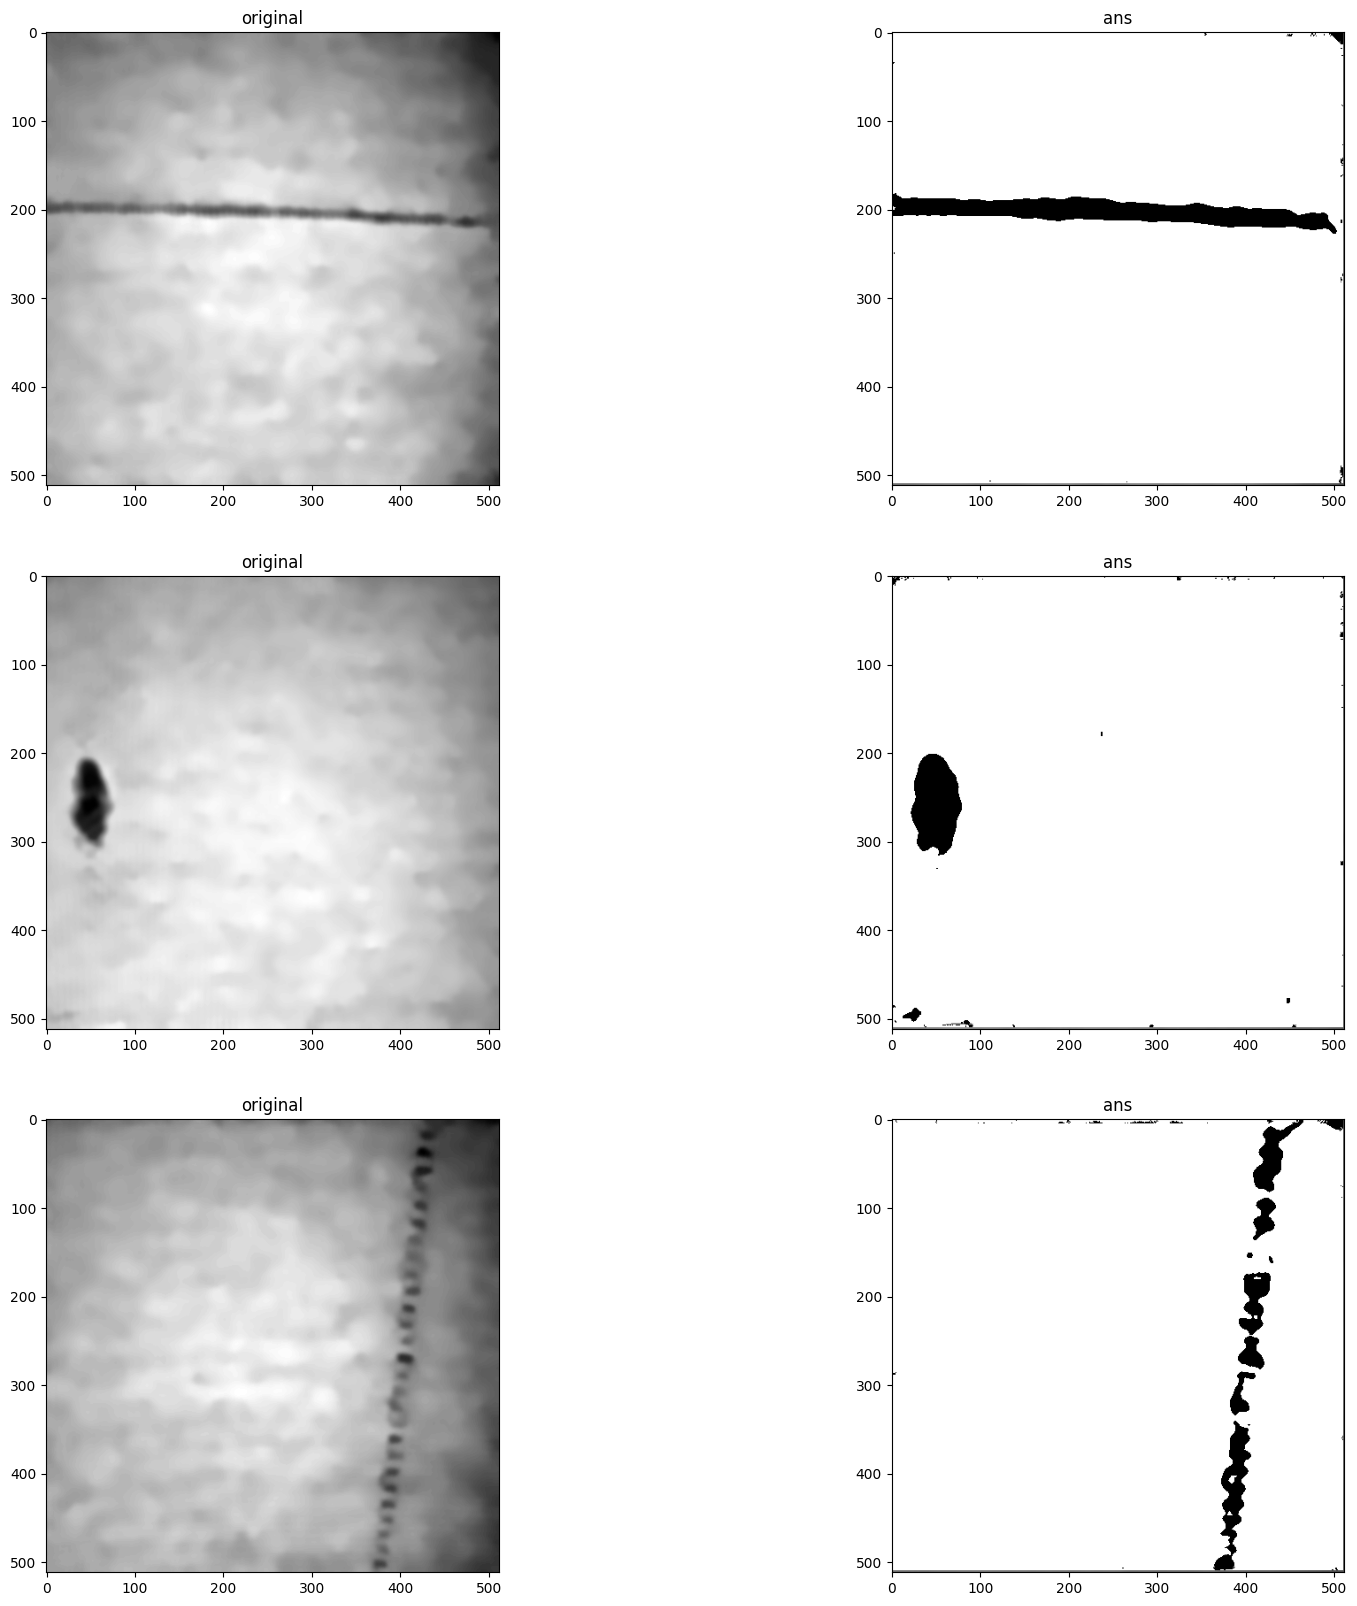

In [10]:
import math
detect_size = 500/pixel
from torchmetrics import PeakSignalNoiseRatio
def img_detect(f):
    empty = f.copy()   
    for x in range (510):
        for y in range(510):
            if(all_pix_row[f[x][y]][f[x][y + 2]] > detect_size and all_pix_col[f[x][y]][f[x + 2][y]] > detect_size):
                empty[x][y] = 255
            else:
                empty[x][y] = 0
    return empty

def PSNR(img1, img2):
    mse = np.mean( (img1/255. - img2/255.) ** 2 )
    if mse < 1.0e-10:
        return 100
    PIXEL_MAX = 1
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def main():
    
    image1_groundtruth = cv2.imread( "image1_groundtruth.png")
    image1_groundtruth = cv2.cvtColor(image1_groundtruth, cv2.COLOR_BGR2GRAY)
    image2_groundtruth = cv2.imread( "image2_groundtruth.png")
    image2_groundtruth = cv2.cvtColor(image2_groundtruth, cv2.COLOR_BGR2GRAY)
    image4_groundtruth = cv2.imread( "image4_groundtruth.png")
    image4_groundtruth = cv2.cvtColor(image4_groundtruth, cv2.COLOR_BGR2GRAY)
    
#   img1
    image1 = cv2.imread( "image1.png")
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image1_bc = beta_correction(image1)
    image1_b = cv2.blur(image1_bc, (blur_size,blur_size))
###  
    f = np.fft.fft2(image1_b)
    fshift = np.fft.fftshift(f)
    phase_spectrumR = np.angle(fshift)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    img_shape = image1.shape
    NotchRejectCenter = fshift * NotchFilter 
    NotchReject = np.fft.ifftshift(NotchRejectCenter)
    inverse_NotchReject = np.fft.ifft2(NotchReject)  # Compute the inverse DFT of the result
    image1_n = np.abs(inverse_NotchReject)
    image1_n = np.uint8(image1_n)
### 
    image1_s = sharpen(image1_n)
    image1_f = cv2.fastNlMeansDenoising(image1_s, None, 10, 7, 21)
    image1_c = img_detect(image1_f)
    image1_m = median_filter(image1_c)
    

#   img2
    image2 = cv2.imread( "image2.png")
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    image2_bc = beta_correction(image2)
    image2_b = cv2.blur(image2_bc, (blur_size,blur_size))
###  
    f = np.fft.fft2(image2_b)
    fshift = np.fft.fftshift(f)
    phase_spectrumR = np.angle(fshift)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    img_shape = image2.shape
    NotchRejectCenter = fshift * NotchFilter 
    NotchReject = np.fft.ifftshift(NotchRejectCenter)
    inverse_NotchReject = np.fft.ifft2(NotchReject)  # Compute the inverse DFT of the result
    image2_n = np.abs(inverse_NotchReject)
    image2_n = np.uint8(image2_n)
### 
    image2_s = sharpen(image2_n)
    image2_f = cv2.fastNlMeansDenoising(image2_s, None, 10, 7, 21)
    image2_c = img_detect(image2_f)
    image2_m = median_filter(image2_c)
    
    
#   img4
    image4 = cv2.imread( "image4.png")
    image4 = cv2.cvtColor(image4, cv2.COLOR_BGR2GRAY)
    image4_bc = beta_correction(image4)
    image4_b = cv2.blur(image4_bc, (blur_size,blur_size))
###  
    f = np.fft.fft2(image4_b)
    fshift = np.fft.fftshift(f)
    phase_spectrumR = np.angle(fshift)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    img_shape = image4.shape
    NotchRejectCenter = fshift * NotchFilter 
    NotchReject = np.fft.ifftshift(NotchRejectCenter)
    inverse_NotchReject = np.fft.ifft2(NotchReject)  # Compute the inverse DFT of the result
    image4_n = np.abs(inverse_NotchReject)
    image4_n = np.uint8(image4_n)
### 
    image4_s = sharpen(image4_n)
    image4_f = cv2.fastNlMeansDenoising(image4_s, None, 10, 7, 21)
    image4_c = img_detect(image4_f)
    image4_m = median_filter(image4_c)
    
    
#     print(PSNR(image1_groundtruth, image1_m))
#     print(PSNR(image2_groundtruth, image2_m))
#     print(PSNR(image4_groundtruth, image4_m))

    
    plt.figure(figsize=(20, 20))
    plt.subplot(3,2,1)   
    plt.title('original') 
    plt.imshow(image1_f,cmap=plt.cm.gray)
    plt.subplot(3,2,2)    
    plt.title('ans') 
    plt.imshow(image1_m,cmap=plt.cm.gray)
    
    plt.subplot(3,2,3)    
    plt.title('original') 
    plt.imshow(image2_f,cmap=plt.cm.gray)
    plt.subplot(3,2,4)    
    plt.title('ans') 
    plt.imshow(image2_m,cmap=plt.cm.gray)
    
    plt.subplot(3,2,5)    
    plt.title('original') 
    plt.imshow(image4_f,cmap=plt.cm.gray)
    plt.subplot(3,2,6)    
    plt.title('ans') 
    plt.imshow(image4_m,cmap=plt.cm.gray)

main()